# MIS6380 Big Data Final Project

In this project, we will assign risk values to drivers in a truck fleet, and develop a strategy to reduce the overall risk of the fleet.

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
import numpy as np

In [2]:
truck_df = pd.read_csv("/Users/srinivas/Downloads/trucks.csv")
geo_df = pd.read_csv("/Users/srinivas/Downloads/geolocation (1).csv")
county_df = pd.read_csv("/Users/srinivas/Downloads/travel-and-crash-summary-for-county.csv")
ctc_df = pd.read_csv("/Users/srinivas/Downloads/Cali City County Code.csv")

# Assigning Risk

### Step 1. Trucks Dataset Analysis

In [3]:
#Select the columns in truck_df with the name miles
mile_col = [col for col in truck_df.columns if "miles" in col]

In [4]:
#Create a column giving the total number of miles driven
truck_df["Total Miles"] = truck_df[mile_col].sum(axis = 1)
truck_df_sorted = truck_df.sort_values(by='model')
truck_df.head()

,driverid,truckid,model,jun13_miles,jun13_gas,may13_miles,may13_gas,apr13_miles,apr13_gas,mar13_miles,...,may09_gas,apr09_miles,apr09_gas,mar09_miles,mar09_gas,feb09_miles,feb09_gas,jan09_miles,jan09_gas,Total Miles
0,A1,A1,Freightliner,9217,1914,8769,1892,14234,3008,11519,...,2642,15276,2642,9880,2642,13861,2642,11176,2642,628507
1,A2,A2,Ford,12058,2335,14314,2648,11050,2323,14114,...,1827,11892,1827,15158,1827,12774,1827,11743,1827,664543
2,A3,A3,Ford,13652,2899,12075,2603,12277,2792,9642,...,3064,15224,3064,11209,3064,14203,3064,10150,3064,639584
3,A4,A4,Kenworth,12687,2439,10680,2083,11071,2599,12302,...,2965,14684,2965,13090,2965,15090,2965,14249,2965,663289
4,A5,A5,Hino,10233,1825,14634,3450,9281,2028,13547,...,2310,14289,2310,13046,2310,9582,2310,10509,2310,676574


/var/folders/7s/p_dkbml15ts8jfqmg89nydhc0000gn/T/ipykernel_70172/2902495295.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = get_cmap("tab20_r").colors


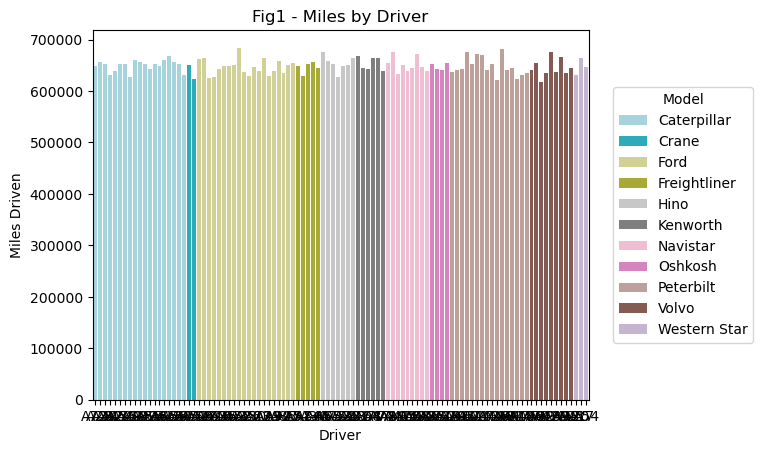

In [5]:
#Plot the Miles driven for each driver, colored by the vehicle model
colors = get_cmap("tab20_r").colors

sns.barplot(x = 'driverid', y = "Total Miles", hue = "model", data = truck_df_sorted, dodge = False, palette = colors)
plt.title("Fig1 - Miles by Driver")
plt.xlabel('Driver')
plt.ylabel("Miles Driven")
plt.legend(title='Model', bbox_to_anchor=(1.05, 0.5), loc='center left', borderaxespad=0.)

We started by plotting the miles driven by each driver, colored by car model. Here, we see that the drivers all drive roughly 650,000 miles, but there is much more variance in the number of drivers for each truck.

Now that we've seen that there aren't outliers in the miles for each driver, we can use miles as a basis for normalization of incidents.

If a model like Crane is selected as the safest truck, the low amount of datapoints may cause us to reconsider.


In [6]:
model_miles_df = truck_df.groupby('model')['Total Miles'].sum().reset_index()
model_miles_df.rename(columns={'Total Miles': 'Model Miles'}, inplace=True)

model_miles_df.head()

,model,Model Miles
0,Caterpillar,12340709
1,Crane,1272409
2,Ford,12941439
3,Freightliner,3228841
4,Hino,4579929


In [7]:
#Add the total number of miles associated with a model to the truck_df
truck_df = pd.merge(truck_df, model_miles_df, on='model', how='left')
truck_df.head()

,driverid,truckid,model,jun13_miles,jun13_gas,may13_miles,may13_gas,apr13_miles,apr13_gas,mar13_miles,...,apr09_miles,apr09_gas,mar09_miles,mar09_gas,feb09_miles,feb09_gas,jan09_miles,jan09_gas,Total Miles,Model Miles
0,A1,A1,Freightliner,9217,1914,8769,1892,14234,3008,11519,...,15276,2642,9880,2642,13861,2642,11176,2642,628507,3228841
1,A2,A2,Ford,12058,2335,14314,2648,11050,2323,14114,...,11892,1827,15158,1827,12774,1827,11743,1827,664543,12941439
2,A3,A3,Ford,13652,2899,12075,2603,12277,2792,9642,...,15224,3064,11209,3064,14203,3064,10150,3064,639584,12941439
3,A4,A4,Kenworth,12687,2439,10680,2083,11071,2599,12302,...,14684,2965,13090,2965,15090,2965,14249,2965,663289,3921818
4,A5,A5,Hino,10233,1825,14634,3450,9281,2028,13547,...,14289,2310,13046,2310,9582,2310,10509,2310,676574,4579929


In [8]:
fig1 = truck_df

 ### Step 2. Geo Dataset Analysis

First, we'll enrich the data by finding the county each city belongs to for future analysis.

In [9]:
#This code joins the county name to its abbreviation, then filters to only show the total crashes by county
county_df = pd.merge(county_df,ctc_df, left_on = ["COUNTY"], right_on = ["Abbrev"], how = 'left')
county_df = county_df.query('RURAL_URBAN == "COUNTYWIDE" and LANE_TYPE == "     TOTAL"')
county_df = county_df[["COUNTY","County","TOTAL_CRASHES","ROAD_MILES"]]

county_df['TOTAL_CRASHES'] = county_df['TOTAL_CRASHES'].str.replace(',', '', regex=False).astype(float)
county_df['ROAD_MILES'] = county_df['ROAD_MILES'].str.replace(',', '', regex=False).astype(float)

Then, we add a "Danger" column, associating the event to the geographic risk of traveling in that area.

In [10]:
# Safely calculate the 'Danger' column, avoiding division by zero
county_df['Danger'] = np.where(county_df['ROAD_MILES'] != 0, 
                                county_df['TOTAL_CRASHES'] / county_df['ROAD_MILES'], 
                                np.nan)  # Replace division by zero with NaN

#Finally, the result of "Danger" is divided by 50, then 1 is added, so the danger scale ranges from roughly 1 to 3
county_df['Danger'] = county_df['Danger'] / 50 + 1

county_df.head()

,COUNTY,County,TOTAL_CRASHES,ROAD_MILES,Danger
26,ALA,Alameda,9207.0,194.8,1.945277
53,ALP,Alpine,45.0,82.7,1.010883
80,AMA,Amador,195.0,125.7,1.031026
107,BUT,Butte,607.0,181.8,1.066777
134,CAL,Calaveras,298.0,150.2,1.039680


Then, we'll join the data from our previous datasets.

In [11]:
truck_df = truck_df[['driverid','Total Miles','model', 'Model Miles']]
accident_df = pd.merge(truck_df, geo_df, on='driverid', how='inner')
accident_df = pd.merge(accident_df, county_df, left_on='city', right_on='County', how='left')
accident_df['Danger'] = accident_df['Danger'].fillna(1)
accident_df['event_weight'] = accident_df['event_ind'] * (1 / accident_df['Danger'])

accident_df.head()

,driverid,Total Miles,model,Model Miles,truckid,event,latitude,longitude,city,state,velocity,event_ind,idling_ind,COUNTY,County,TOTAL_CRASHES,ROAD_MILES,Danger,event_weight
0,A1,628507,Freightliner,3228841,A1,normal,36.977173,-121.899402,Aptos,California,75,0,0,NaN,NaN,NaN,NaN,1.0,0.0
1,A1,628507,Freightliner,3228841,A1,normal,35.098865,-120.612393,Oceano,California,34,0,0,NaN,NaN,NaN,NaN,1.0,0.0
2,A1,628507,Freightliner,3228841,A1,normal,37.005782,-121.568275,Gilroy,California,19,0,0,NaN,NaN,NaN,NaN,1.0,0.0
3,A1,628507,Freightliner,3228841,A1,normal,37.639097,-120.996878,Modesto,California,75,0,0,NaN,NaN,NaN,NaN,1.0,0.0
4,A1,628507,Freightliner,3228841,A1,normal,34.579434,-118.116461,Palmdale,California,55,0,0,NaN,NaN,NaN,NaN,1.0,0.0


In [12]:
print(accident_df['event'].unique())

['normal' 'unsafe tail distance' 'lane departure'
 'unsafe following distance' 'overspeed']


Next, we'll do some exploratory analysis of the geo dataset, starting with a histogram plotting the number of non-normal events by each driver.

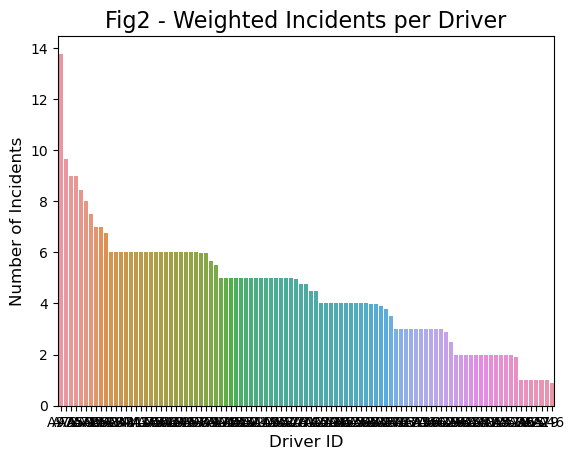

In [13]:
#Create a dataframe listing the count of non-normal incidents by driver
df_filtered = accident_df[accident_df['event'] != 'normal']
incident_counts = df_filtered.groupby(['driverid', 'model'])['event_weight'].sum().reset_index(name='incident_count')
incident_counts = incident_counts.sort_values(by='incident_count', ascending=False)

#Plot the data on a histogram
sns.barplot(data=incident_counts, x='driverid', y='incident_count', dodge=False)
plt.title("Fig2 - Weighted Incidents per Driver", fontsize=16)
plt.xlabel("Driver ID", fontsize=12)
plt.ylabel("Number of Incidents", fontsize=12)

fig2 = incident_counts

In [14]:
# Calculate Z-scores for the incident counts
mean_incidents = incident_counts['incident_count'].mean()
std_incidents = incident_counts['incident_count'].std()

# Calculate the Z-score for each driver
incident_counts['z_score'] = (incident_counts['incident_count'] - mean_incidents) / std_incidents

# Filter drivers with Z-score greater than 3
drivers_high_z_score = incident_counts[incident_counts['z_score'] > 3]

# Show the results
print("Drivers with Z-score greater than 3:")
print(drivers_high_z_score[['driverid', 'incident_count', 'z_score']])

Drivers with Z-score greater than 3:
   driverid  incident_count  z_score
96      A97       13.770493  4.28672


Since driver A97 has a z-score of 4, we chose to remove them. Their events likely represent an abnormally risky driver compared to the rest of the fleet.

In [15]:
#Remove driver A97
accident_df = accident_df[accident_df['driverid'] != 'A97']

Text(0.5, 1.0, 'Fig3.1 - Events by Velocity')

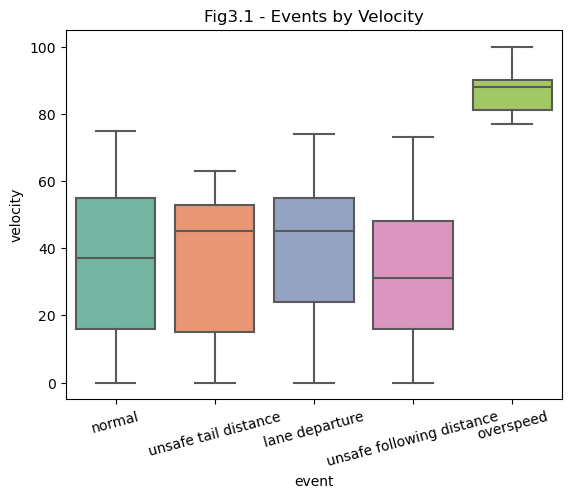

In [16]:
#Boxplot for each event by velocity
sns.boxplot(x='event', y='velocity', data=accident_df, palette="Set2")
plt.xticks(rotation=15)
plt.title("Fig3.1 - Events by Velocity")

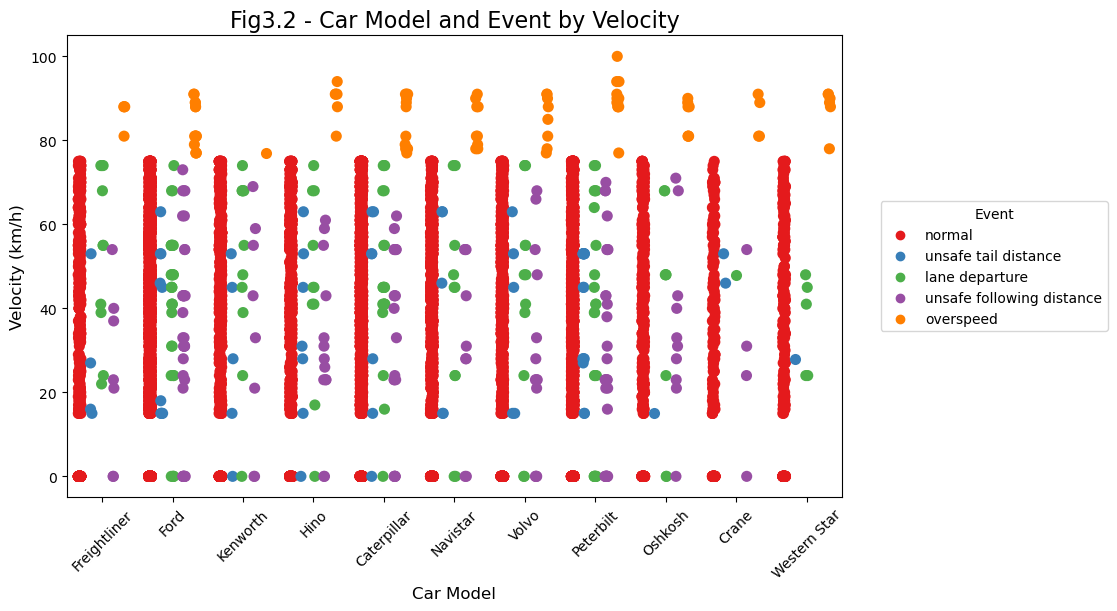

In [17]:
#Creates a stripplot showing the events for each car plotted against the velocity it occured at
plt.figure(figsize=(10, 6))
sns.stripplot(x='model', y='velocity', hue='event', data=accident_df, dodge=True, palette='Set1', size=8)

# Title and labels
plt.title("Fig3.2 - Car Model and Event by Velocity", fontsize=16)
plt.xlabel("Car Model", fontsize=12)
plt.ylabel("Velocity (km/h)", fontsize=12)

# Rotate x-axis labels for readability
plt.xticks(rotation=45)

plt.legend(title='Event', bbox_to_anchor=(1.05, 0.5), loc='center left', borderaxespad=0.)

fig3 = accident_df

To best address the risk of the trucks, we've decided to only consider 'unsafe tail distance', 'unsafe following distance', and 'lane departure' in our analysis, as 'overspeed' is purely a result of the driver.

In [18]:
#Keeps only the 3 listed events in the df
accident_df = (accident_df[(accident_df['event'] == 'unsafe tail distance') | 
                           (accident_df['event'] == 'unsafe following distance') |
                           (accident_df['event'] == 'lane departure')])

In [19]:
accident_df.head()

,driverid,Total Miles,model,Model Miles,truckid,event,latitude,longitude,city,state,velocity,event_ind,idling_ind,COUNTY,County,TOTAL_CRASHES,ROAD_MILES,Danger,event_weight
18,A1,628507,Freightliner,3228841,A1,unsafe tail distance,38.693723,-119.779683,Markleeville,California,16,1,0,NaN,NaN,NaN,NaN,1.0,1.0
37,A1,628507,Freightliner,3228841,A1,lane departure,38.440467,-122.714431,Santa Rosa,California,24,1,0,NaN,NaN,NaN,NaN,1.0,1.0
48,A1,628507,Freightliner,3228841,A1,lane departure,36.977173,-121.899402,Aptos,California,74,1,0,NaN,NaN,NaN,NaN,1.0,1.0
112,A2,664543,Ford,12941439,A2,lane departure,39.017396,-122.057748,Arbuckle,California,24,1,0,NaN,NaN,NaN,NaN,1.0,1.0
182,A3,639584,Ford,12941439,A3,unsafe following distance,39.150171,-123.207783,Ukiah,California,31,1,0,NaN,NaN,NaN,NaN,1.0,1.0


Now we'll sum the weighted event counts per vehicle, and create a barchart showcasing their occurance.

In [20]:
# Group by model and incident type to get the count of events per model
event_counts = accident_df.groupby(['model', 'event'])['event_weight'].sum().reset_index(name='event_count')

#Merge with total miles
event_counts = pd.merge(event_counts, model_miles_df, on='model')

#Normalizing
event_counts['event_per_mil_mile'] = (event_counts['event_count']*1000000) / event_counts['Model Miles']

#Sum the relative event counts per model (by summing 'event_per_mil_mile')
model_relative_event_counts = event_counts.groupby('model')['event_per_mil_mile'].sum().reset_index(name='total_relative_event_count')

#Sort the models by the total relative event count, in descending order
model_relative_event_counts = model_relative_event_counts.sort_values(by='total_relative_event_count', ascending=False)

#Create a mapping to reorder the models in `event_counts`
model_order = model_relative_event_counts['model'].tolist()

#Reorder the rows in event_counts based on the sorted model order
event_counts['model'] = pd.Categorical(event_counts['model'], categories=model_order, ordered=True)

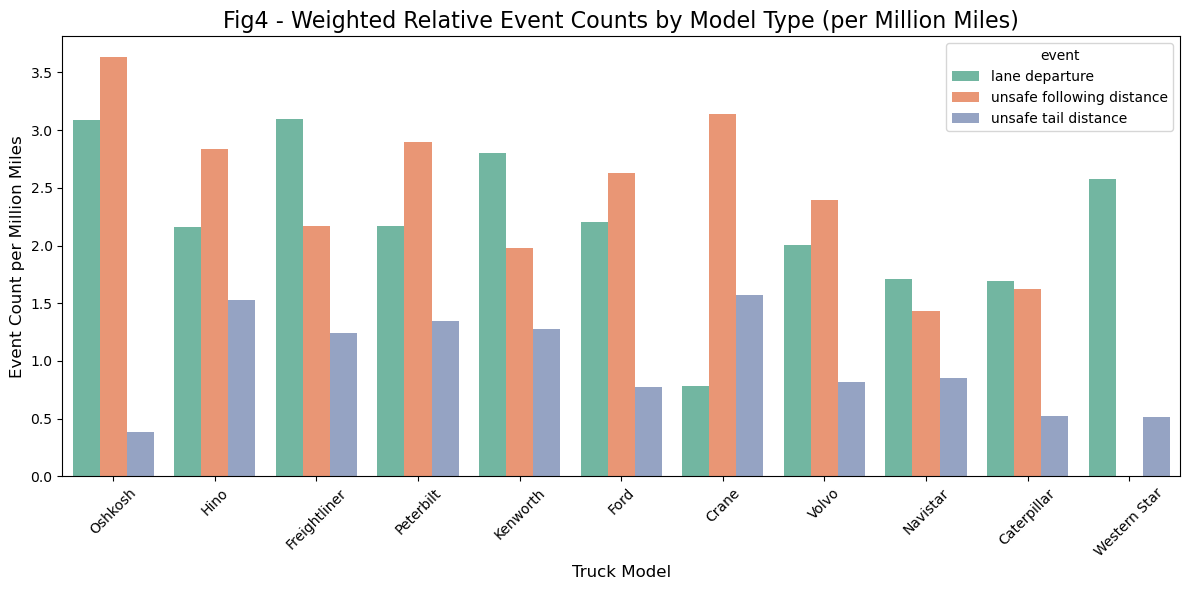

In [21]:
#Plot the bar chart with the models ordered by relative event count
plt.figure(figsize=(12, 6))
sns.barplot(data=event_counts, x='model', y='event_per_mil_mile', hue='event', dodge=True, palette='Set2')

# Add labels and title
plt.title("Fig4 - Weighted Relative Event Counts by Model Type (per Million Miles)", fontsize=16)
plt.xlabel("Truck Model", fontsize=12)
plt.ylabel("Event Count per Million Miles", fontsize=12)

# Adjust x-axis labels for readability
plt.xticks(rotation=45)  # Rotate x labels for readability

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

fig4 = event_counts

Finally, we can assign a risk factor to each truck by summing the 'weighted event count per million miles' for each vehicle.

In [22]:
#Sum the relative event counts per model (by summing 'event_per_mil_mile')
model_relative_event_counts = event_counts.groupby('model')['event_per_mil_mile'].sum().reset_index(name='total_relative_event_count')

#Sort the models by the total relative event count, in descending order (riskiest first)
model_relative_event_counts = model_relative_event_counts.sort_values(by='total_relative_event_count', ascending=False)

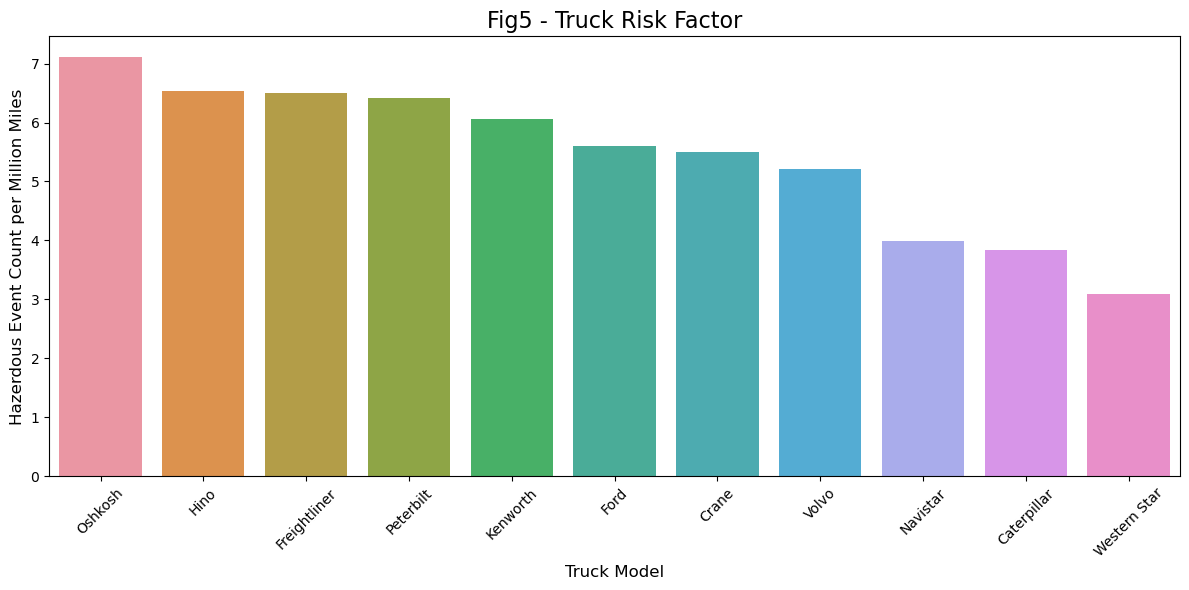

In [23]:
#Plot the bar chart showing the total sum of events per model (sorted by riskiness)
plt.figure(figsize=(12, 6))
sns.barplot(data=model_relative_event_counts, x='model', y='total_relative_event_count')

# Add labels and title
plt.title("Fig5 - Truck Risk Factor", fontsize=16)
plt.xlabel("Truck Model", fontsize=12)
plt.ylabel("Hazerdous Event Count per Million Miles", fontsize=12)

# Adjust x-axis labels for readability
plt.xticks(rotation=45)  # Rotate x labels for readability

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

The truck risk factor will now be assigned back to the truck_df.

In [24]:
truck_df = pd.merge(truck_df, model_relative_event_counts, on='model', how='left')
truck_df.rename(columns={'total_relative_event_count': 'Model Risk Factor'}, inplace=True)

fig5 = truck_df

### Step 3. Save Dataframes

Well use these dataframes to recreate the visualizations in Tableau.

In [25]:
#Miles by driver
fig1.to_csv('fig1.csv')

#Weighted incidents by driver
fig2.to_csv('fig2.csv')

#Events by velocity, car model and event by velocity
fig3.to_csv('fig3.csv')

#Events by model (weighted, relative)
fig4.to_csv('fig4.csv')

#Truck Risk Factor
fig5.to_csv('fig5.csv')

In [26]:
print('done')

done
